In [2]:
import torch.nn as nn

# Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

# ConvMixer model with hard-coded parameters
def ConvMixer():
    dim = 256          # Embedding dimension
    depth = 8          # Number of ConvMixer blocks
    kernel_size = 5    # Kernel size for depthwise convolution
    patch_size = 4     # Patch size for initial convolution
    n_classes = 10     # CIFAR-10 has 10 classes

    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for _ in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [3]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

dataset = datasets.Imagenette(root='/home/j597s263/scratch/j597s263/Datasets/imagenette', download=False, transform=transform)

random.seed(42) 
indices = list(range(len(dataset)))
random.shuffle(indices)

# Split shuffled indices into training and testing
train_indices = indices[:7568]
test_indices = indices[7568:8522]
attack_indices = indices[8522:]

# Create Subsets
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)
attack_data = Subset(dataset, attack_indices)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle within batches
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)  # No shuffle for test set
attack_loader = DataLoader(attack_data, batch_size=1, shuffle=False)  # Batch size 1 for mask intersection

# Load the model
model = torch.load('/home/j597s263/scratch/j597s263/Models/ConvModels/Conv_Imagenette.mod', weights_only=False, map_location="cuda:0")
model = model.to('cuda')
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [4]:
import numpy as np
import matplotlib.pyplot as plt

lime_explanations = np.load('/home/j597s263/scratch/j597s263/Datasets/Explanation_values/lime_ConvImag.npy', allow_pickle=True)

print(f"Number of explanations: {len(lime_explanations)}")
print(f"Example explanation: {lime_explanations[0]}")

Number of explanations: 947
Example explanation: {'index': 0, 'label': 8, 'mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}


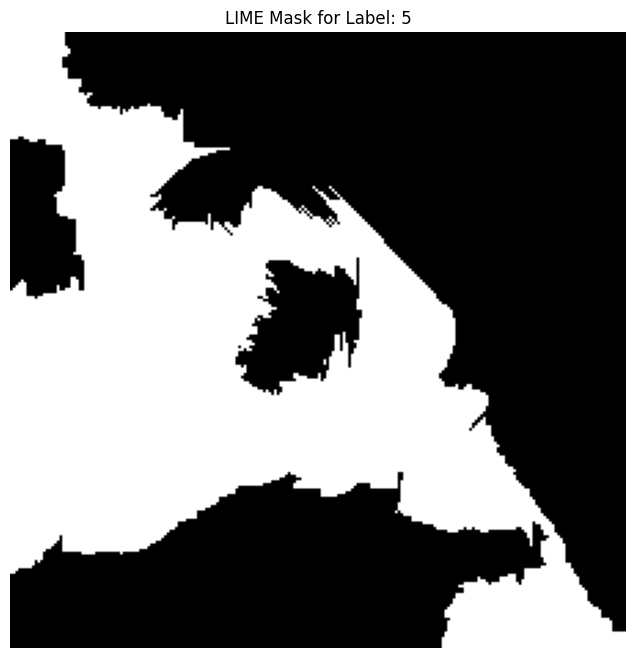

In [9]:
import numpy as np
import matplotlib.pyplot as plt

lime_explanations = np.load('/home/j597s263/scratch/j597s263/Datasets/Explanation_values/lime_ConvImag.npy', allow_pickle=True)

first_explanation = lime_explanations[434]

first_mask = first_explanation['mask']
first_label = first_explanation['label']

plt.figure(figsize=(8, 8))
plt.imshow(first_mask, cmap='gray')
plt.title(f"LIME Mask for Label: {first_label}")
plt.axis('off')
plt.show()

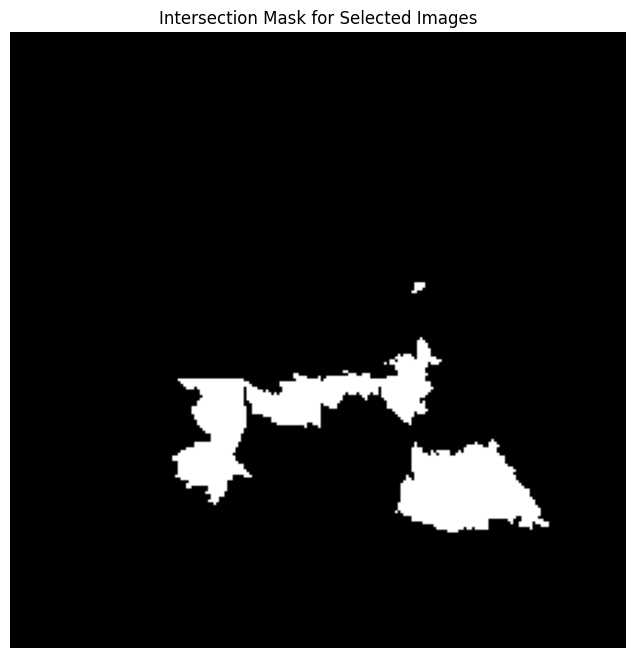

Intersection Mask Summary:
Shape: (224, 224)
Unique Values: [False  True]


In [20]:
import numpy as np
import matplotlib.pyplot as plt

#selected_indices = list(range(len(lime_explanations)))  
selected_indices = [0, 131, 43, 434]

intersection_mask = np.ones_like(lime_explanations[0]['mask'], dtype=bool)

for i in selected_indices:
    explanation = lime_explanations[i]
    mask = explanation['mask']
    intersection_mask = np.logical_and(intersection_mask, mask)

    '''plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='gray')
    plt.title(f"LIME Mask for Explanation {i}, Label: {explanation['label']}")
    plt.axis('off')
    plt.show()'''

plt.figure(figsize=(8, 8))
plt.imshow(intersection_mask, cmap='gray')
plt.title("Intersection Mask for Selected Images")
plt.axis('off')
plt.show()

print("Intersection Mask Summary:")
print(f"Shape: {intersection_mask.shape}")
print(f"Unique Values: {np.unique(intersection_mask)}")